# About Dataset

### Context

This an example data source which can be used for Predictive Maintenance Model Building. It consists of the following data:

Machine conditions and usage: The operating conditions of a machine e.g. data collected from sensors.

Failure history: The failure history of a machine or component within the machine.

Maintenance history: The repair history of a machine, e.g. error codes, previous maintenance activities or component replacements.

Machine features: The features of a machine, e.g. engine size, make and model, location.

### Files Details

Telemetry Time Series Data (PdM_telemetry.csv): It consists of hourly average of voltage, rotation, pressure, vibration collected from 100 machines for the year 2015.

Error (PdM_errors.csv): These are errors encountered by the machines while in operating condition. Since, these errors don't shut down the machines, these are not considered as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.

Maintenance (PdM_maint.csv): If a component of a machine is replaced, that is captured as a record in this table. Components are replaced under two situations: 1. During the regular scheduled visit, the technician replaced it (Proactive Maintenance) 2. A component breaks down and then the technician does an unscheduled maintenance to replace the component (Reactive Maintenance). This is considered as a failure and corresponding data is captured under Failures. Maintenance data has both 2014 and 2015 records. This data is rounded to the closest hour since the telemetry data is collected at an hourly rate.

Failures (PdM_failures.csv): Each record represents replacement of a component due to failure. This data is a subset of Maintenance data. This data is rounded to the closest hour since the telemetry data is collected at an hourly rate.

Metadata of Machines (PdM_Machines.csv): Model type & age of the Machines.

In [2]:
## Import Libraries

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error


## Avoid some version change warnings
import warnings
warnings.filterwarnings('ignore', message='numpy.dtype size changed')

In [3]:
## Loading data

telemetry = pd.read_csv('C:/Users/Ton/Desktop/Data_Institute/_prj_01/Microsoft Azure Predictive Maintenance/PdM_telemetry.csv')
error = pd.read_csv('C:/Users/Ton/Desktop/Data_Institute/_prj_01/Microsoft Azure Predictive Maintenance/PdM_errors.csv')
maint = pd.read_csv('C:/Users/Ton/Desktop/Data_Institute/_prj_01/Microsoft Azure Predictive Maintenance/PdM_maint.csv')
failure = pd.read_csv('C:/Users/Ton/Desktop/Data_Institute/_prj_01/Microsoft Azure Predictive Maintenance/PdM_failures.csv')
machine = pd.read_csv('C:/Users/Ton/Desktop/Data_Institute/_prj_01/Microsoft Azure Predictive Maintenance/PdM_machines.csv')


# INITIAL EDA

In [4]:
# Machine hours 2015
print(telemetry.head(5))
print(telemetry.tail(5))

              datetime  machineID        volt      rotate    pressure  \
0  2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1  2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2  2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3  2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4  2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration  
0  45.087686  
1  43.413973  
2  34.178847  
3  41.122144  
4  25.990511  
                   datetime  machineID        volt      rotate    pressure  \
876095  2016-01-01 02:00:00        100  179.438162  395.222827  102.290715   
876096  2016-01-01 03:00:00        100  189.617555  446.207972   98.180607   
876097  2016-01-01 04:00:00        100  192.483414  447.816524   94.132837   
876098  2016-01-01 05:00:00        100  165.475310  413.771670  104.081073   
876099  2016-01-01 06:00:00        100  171.336037  496.096870   79.095538   

  

In [5]:
# Not related to the prediction
print(error.head())
print(error.tail())
print(sorted(error['errorID'].unique()))

              datetime  machineID errorID
0  2015-01-03 07:00:00          1  error1
1  2015-01-03 20:00:00          1  error3
2  2015-01-04 06:00:00          1  error5
3  2015-01-10 15:00:00          1  error4
4  2015-01-22 10:00:00          1  error4
                 datetime  machineID errorID
3914  2015-11-21 08:00:00        100  error2
3915  2015-12-04 02:00:00        100  error1
3916  2015-12-08 06:00:00        100  error2
3917  2015-12-08 06:00:00        100  error3
3918  2015-12-22 03:00:00        100  error3
['error1', 'error2', 'error3', 'error4', 'error5']


In [6]:
# Replacements date of components, use this dataset to calculate life expectency of components
print(maint.head(5))
#print(maint.tail())

              datetime  machineID   comp
0  2014-06-01 06:00:00          1  comp2
1  2014-07-16 06:00:00          1  comp4
2  2014-07-31 06:00:00          1  comp3
3  2014-12-13 06:00:00          1  comp1
4  2015-01-05 06:00:00          1  comp4


In [7]:
# Use this to flag which part replacement causing from failure
print(failure.head())
print(failure.tail())

              datetime  machineID failure
0  2015-01-05 06:00:00          1   comp4
1  2015-03-06 06:00:00          1   comp1
2  2015-04-20 06:00:00          1   comp2
3  2015-06-19 06:00:00          1   comp4
4  2015-09-02 06:00:00          1   comp4
                datetime  machineID failure
756  2015-11-29 06:00:00         99   comp3
757  2015-12-14 06:00:00         99   comp4
758  2015-02-12 06:00:00        100   comp1
759  2015-09-10 06:00:00        100   comp1
760  2015-12-09 06:00:00        100   comp2


In [8]:
# Machine age find the coorelation if age of machine effect life expectancy of components
print(machine.head(10))
#print(machine.tail())


   machineID   model  age
0          1  model3   18
1          2  model4    7
2          3  model3    8
3          4  model3    7
4          5  model3    2
5          6  model3    7
6          7  model3   20
7          8  model3   16
8          9  model4    7
9         10  model3   10


# Feature engineering
- Use telemetry dataframe to calculate machine working hours for each day
- Preparing dataframe to calculate life expectancy of components
- Create a new dataframe of date vs age of the machine

In [9]:
telemetry['date'] = pd.to_datetime(telemetry['datetime']).dt.date
usage_per_day = telemetry.groupby(['machineID', 'date']).size().reset_index(name='hours_used')
usage_per_day.tail(10)

,machineID,date,hours_used
36590,100,2015-12-23,24
36591,100,2015-12-24,24
36592,100,2015-12-25,24
36593,100,2015-12-26,24
36594,100,2015-12-27,24
36595,100,2015-12-28,24
36596,100,2015-12-29,24
36597,100,2015-12-30,24
36598,100,2015-12-31,24
36599,100,2016-01-01,7


In [10]:
## Use telemetry dataframe to calculate machine working hours for each day
# Convert datetime column to datetime type and extract the date
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'])
telemetry['date'] = telemetry['datetime'].dt.date

# Group by machineID and date, then count the number of occurrences
usage_per_day = telemetry.groupby(['machineID', 'date']).size().reset_index(name='hours_used')

# Display the new dataframe
print(usage_per_day.head(10))

   machineID        date  hours_used
0          1  2015-01-01          18
1          1  2015-01-02          24
2          1  2015-01-03          24
3          1  2015-01-04          24
4          1  2015-01-05          24
5          1  2015-01-06          24
6          1  2015-01-07          24
7          1  2015-01-08          24
8          1  2015-01-09          24
9          1  2015-01-10          24


In [11]:
## Preparing dataframe to calculate life expectancy of parts
# Create a copy of the original maint dataframe
maint_flagged = maint.copy()

# Check if there is a match by merging and comparing the 'comp' and 'failure' columns
maint_flagged['failure'] = maint.apply(lambda row: any((failure['datetime'] == row['datetime']) & 
                                               (failure['machineID'] == row['machineID']) & 
                                               (failure['failure'] == row['comp'])), axis=1)

print(maint_flagged.head(5))



              datetime  machineID   comp  failure
0  2014-06-01 06:00:00          1  comp2    False
1  2014-07-16 06:00:00          1  comp4    False
2  2014-07-31 06:00:00          1  comp3    False
3  2014-12-13 06:00:00          1  comp1    False
4  2015-01-05 06:00:00          1  comp4     True


In [12]:
# Find the duration before changing each individual component
# Convert datetime column to datetime type, forcing errors to NaT (Not a Time)
maint_flagged['datetime'] = pd.to_datetime(maint_flagged['datetime'], errors='coerce')

# Sort the dataframe by machineID, comp, and datetime
maint_flagged = maint_flagged.sort_values(by=['machineID', 'comp', 'datetime'])

# Calculate the duration between consecutive changes for each component of each machine
maint_flagged['duration_days'] = maint_flagged.groupby(['machineID', 'comp'])['datetime'].diff().dt.days
'''
# Convert duration to total number of days
maint_flagged['duration_days'] = maint_flagged['duration'].dt.days
'''
# Display the result
print(maint_flagged.head(5))

              datetime  machineID   comp  failure  duration_days
3  2014-12-13 06:00:00          1  comp1    False            NaN
5  2015-01-05 06:00:00          1  comp1    False           23.0
7  2015-01-20 06:00:00          1  comp1    False           15.0
11 2015-03-06 06:00:00          1  comp1     True           45.0
12 2015-03-21 06:00:00          1  comp1    False           15.0


In [13]:
# Add 'model'  and  'age' column in df 'machine' to df 'machine_flagged'

machine_flagged_02 = pd.merge(maint_flagged, machine, on='machineID', how='left')

# Check if the number of rows in maint_flagged is equal to the number of rows in machine_flagged_02
if maint_flagged.shape[0] == machine_flagged_02.shape[0]:
    print("The number of rows match, no duplicate, can use df machine_flagged_02 for modeling.")
    print(machine_flagged_02.head(5))
else:
    print("The number of rows do not match, duplicates in df machine.")



The number of rows match, no duplicate, can use df machine_flagged_02 for modeling.
             datetime  machineID   comp  failure  duration_days   model  age
0 2014-12-13 06:00:00          1  comp1    False            NaN  model3   18
1 2015-01-05 06:00:00          1  comp1    False           23.0  model3   18
2 2015-01-20 06:00:00          1  comp1    False           15.0  model3   18
3 2015-03-06 06:00:00          1  comp1     True           45.0  model3   18
4 2015-03-21 06:00:00          1  comp1    False           15.0  model3   18


# EDA

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   datetime       3286 non-null   datetime64[ns]
 1   machineID      3286 non-null   int64         
 2   comp           3286 non-null   object        
 3   failure        3286 non-null   bool          
 4   duration_days  2886 non-null   float64       
 5   model          3286 non-null   object        
 6   age            3286 non-null   int64         
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 157.4+ KB
None

Basic Statistics:
                             datetime    machineID   comp failure  \
count                            3286  3286.000000   3286    3286   
unique                            NaN          NaN      4       2   
top                               NaN          NaN  comp2   False   
freq                    

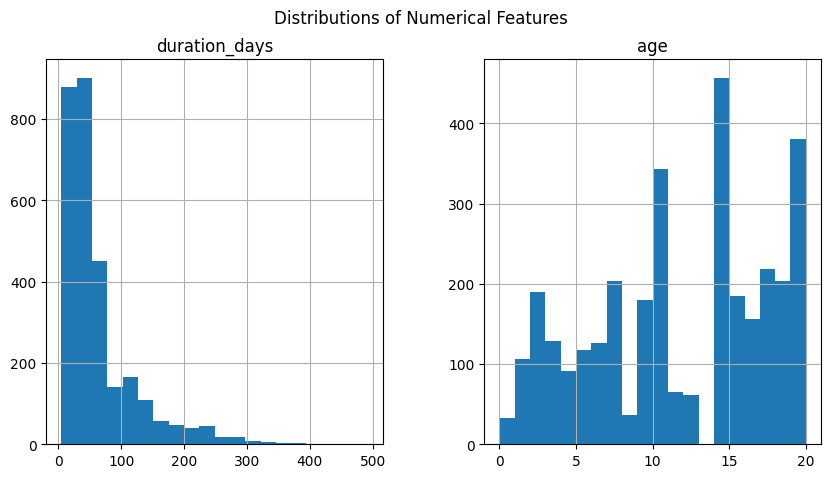

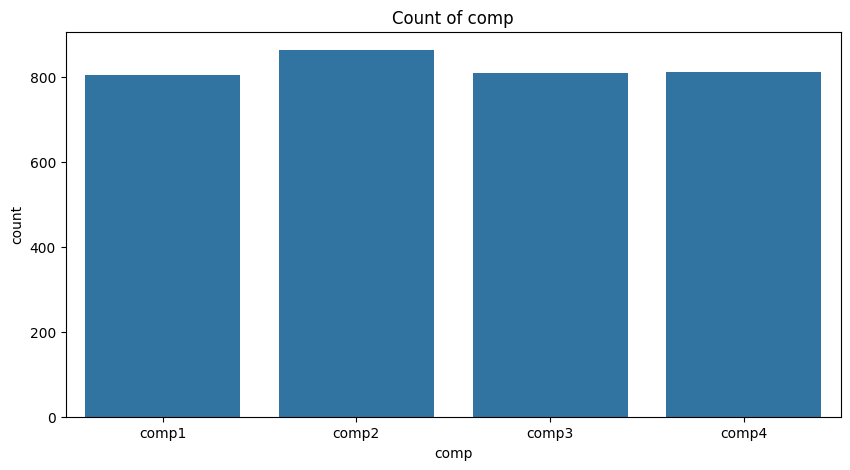

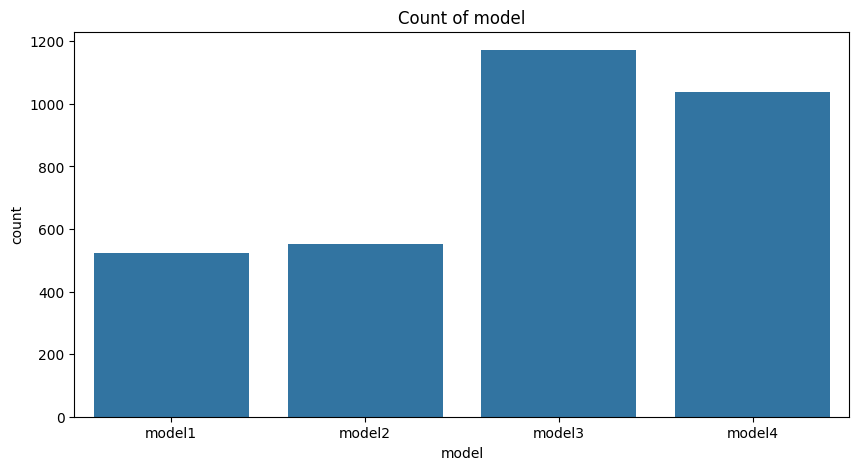

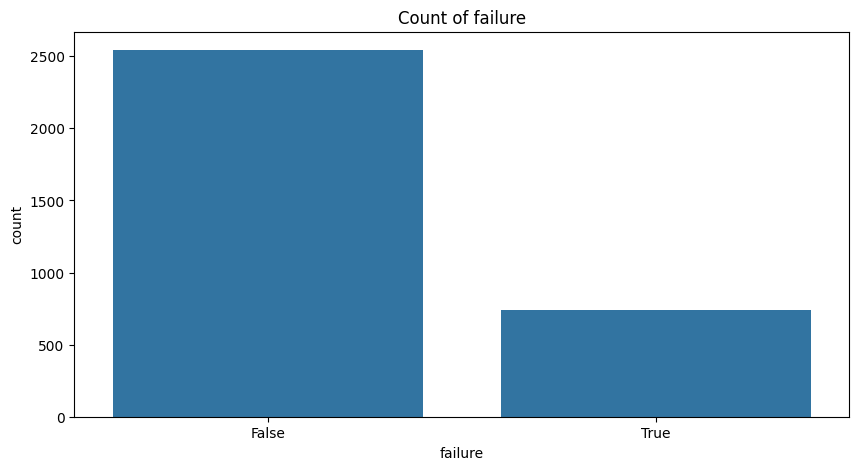

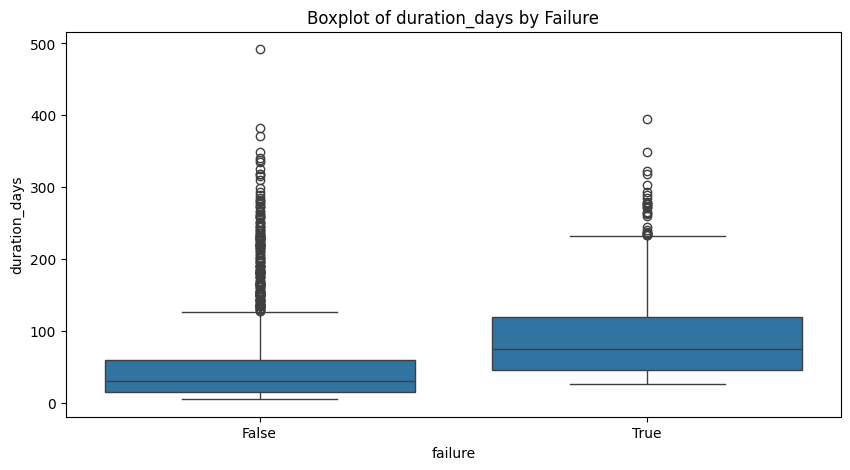

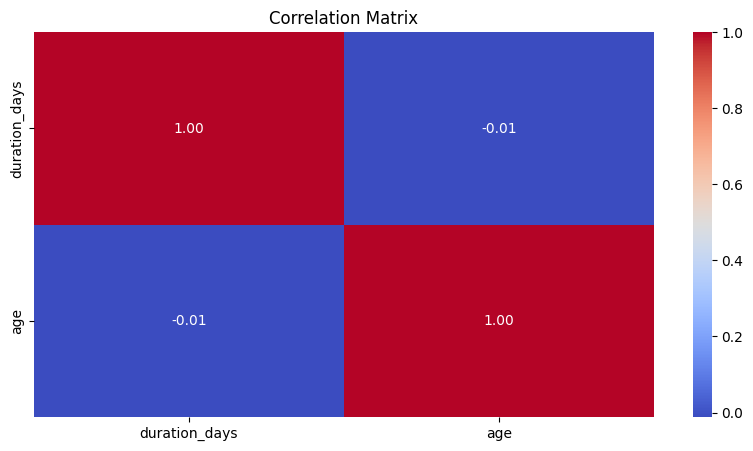

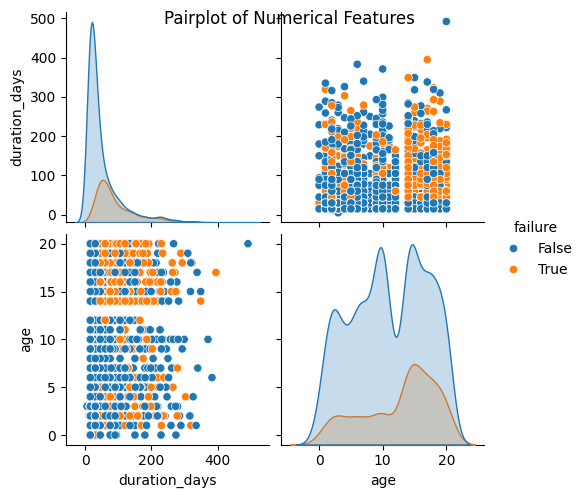


Crosstab of comp and failure:
failure  False  True 
comp                 
comp1      621    183
comp2      607    256
comp3      680    128
comp4      635    176


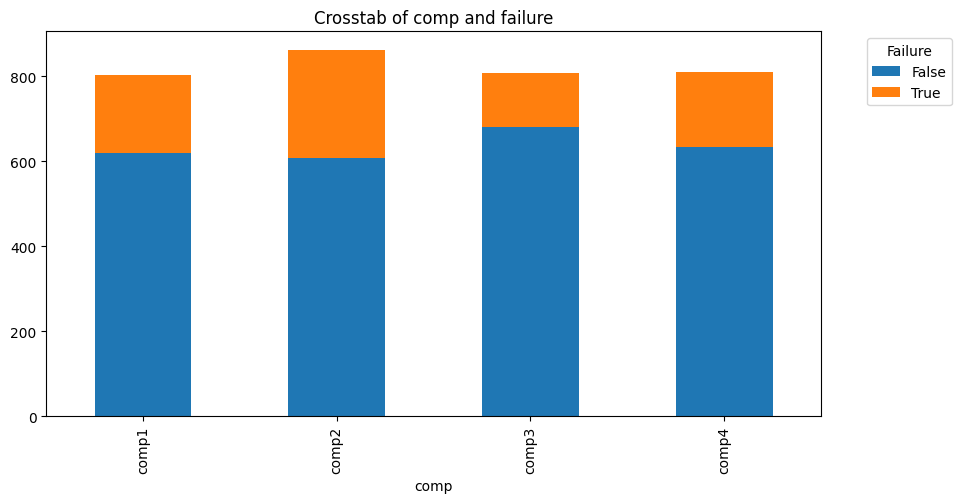


Crosstab of model and failure:
failure  False  True 
model                
model1     341    181
model2     388    165
model3     956    216
model4     858    181


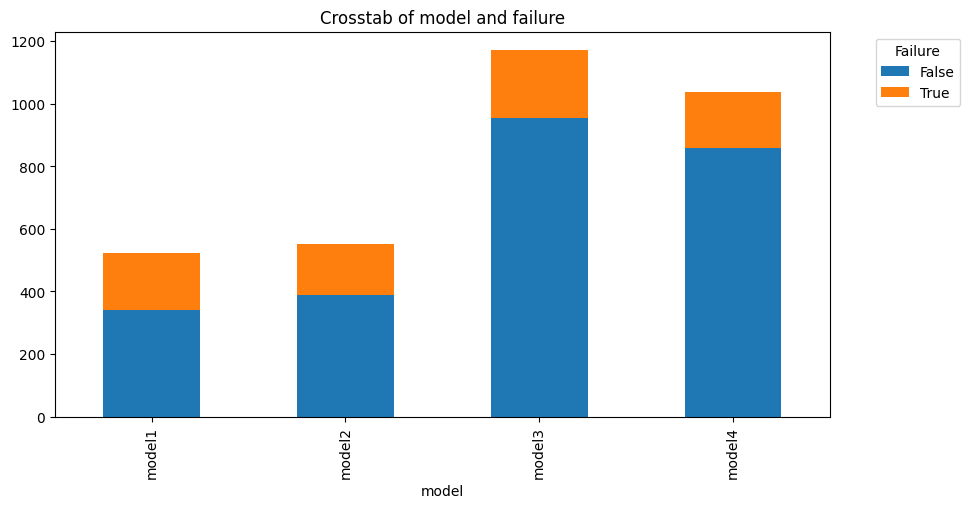

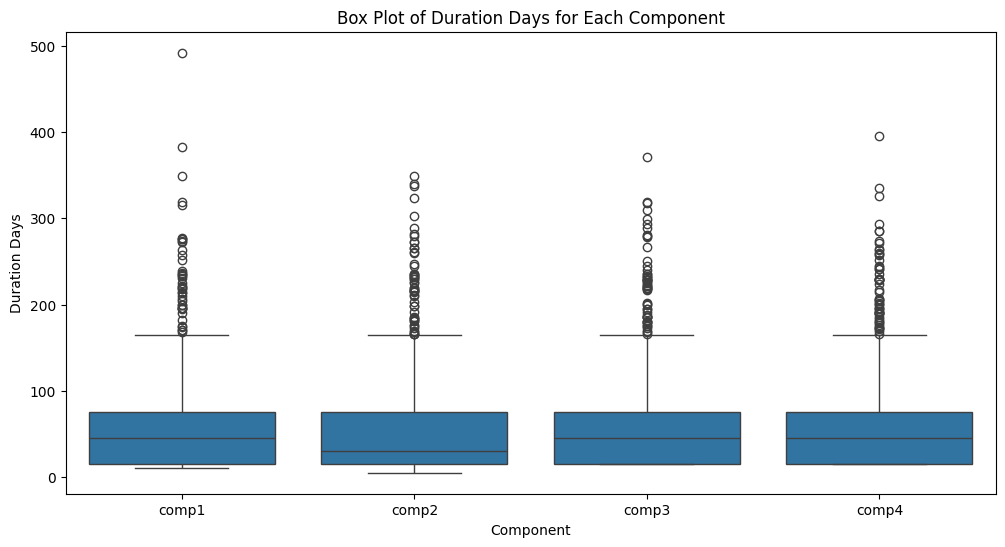

In [14]:
# Display basic information
print("Basic Information:")
print(machine_flagged_02.info())

# Display basic statistics
print("\nBasic Statistics:")
print(machine_flagged_02.describe(include='all'))

# Check for missing values
print("\nMissing Values:")
print(machine_flagged_02.isnull().sum())

# Plotting the distributions of numerical features
num_cols = ['duration_days', 'age']
machine_flagged_02[num_cols].hist(figsize=(10, 5), bins=20)
plt.suptitle('Distributions of Numerical Features')
plt.show()

# Plotting the count of categorical features with sorting
cat_cols = ['comp', 'model', 'failure']
for col in cat_cols:
    plt.figure(figsize=(10, 5))
    order = machine_flagged_02[col].value_counts().sort_index().index
    sns.countplot(data=machine_flagged_02, x=col, order=order)
    plt.title(f'Count of {col}')
    plt.show()

# Boxplot of duration_days by failure
plt.figure(figsize=(10, 5))
sns.boxplot(data=machine_flagged_02, x='failure', y='duration_days')
plt.title('Boxplot of duration_days by Failure')
plt.show()

# Correlation matrix and heatmap for numerical columns
plt.figure(figsize=(10, 5))
num_cols_corr = machine_flagged_02[num_cols].dropna()
corr_matrix = num_cols_corr.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Pairplot of numerical features colored by failure
sns.pairplot(machine_flagged_02, hue='failure', vars=num_cols)
plt.suptitle('Pairplot of Numerical Features')
plt.show()

# Checking the relationship between categorical features and failure
for col in ['comp', 'model']:
    cross_tab = pd.crosstab(machine_flagged_02[col], machine_flagged_02['failure'])
    print(f"\nCrosstab of {col} and failure:")
    print(cross_tab)
    ax = cross_tab.plot(kind='bar', stacked=True, figsize=(10, 5))
    plt.title(f'Crosstab of {col} and failure')
    ax.legend(title='Failure', loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.show()

# Create a box plot of 'duration_days' for each component in 'comp'
plt.figure(figsize=(12, 6))
sns.boxplot(data=machine_flagged_02, x='comp', y='duration_days')
plt.title('Box Plot of Duration Days for Each Component')
plt.xlabel('Component')
plt.ylabel('Duration Days')
plt.show()


### EDA - Finding if there is relationship between model and duration_days, using ANOVA

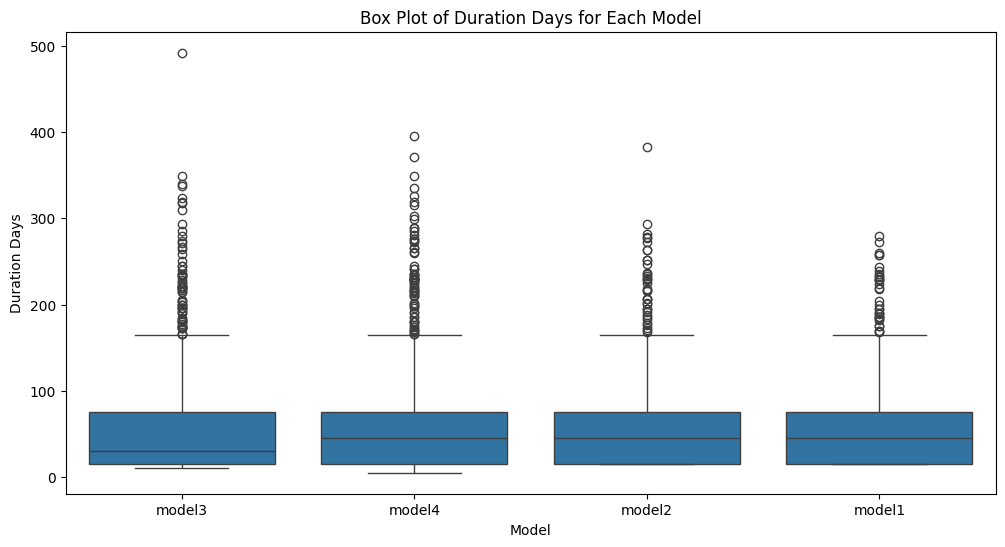

         count       mean        std   min   25%   50%   75%    max
model                                                              
model1   458.0  60.803493  55.129335  15.0  15.0  45.0  75.0  279.0
model2   485.0  62.393814  61.647924  15.0  15.0  45.0  75.0  383.0
model3  1032.0  58.788760  58.996194  11.0  15.0  30.0  75.0  492.0
model4   911.0  61.087816  62.045047   5.0  15.0  45.0  75.0  395.0

ANOVA Result:
F-statistic: 0.4755060322276292
P-value: 0.6993553297604849


In [15]:
import scipy.stats as stats

# Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=machine_flagged_02, x='model', y='duration_days')
plt.title('Box Plot of Duration Days for Each Model')
plt.xlabel('Model')
plt.ylabel('Duration Days')
plt.show()

# Summary Statistics
summary_stats = machine_flagged_02.groupby('model')['duration_days'].describe()
print(f"{summary_stats}\n")

# ANOVA
anova_result = stats.f_oneway(
    *[group['duration_days'].dropna() for name, group in machine_flagged_02.groupby('model')]
)
print(f"ANOVA Result:\nF-statistic: {anova_result.statistic}\nP-value: {anova_result.pvalue}")

Interpretation:
- This p-value is much higher than the common significance threshold (0.05)
- There is no significant relationship between 'model' and 'duration_days'. The different model categories do not have statistically different means for duration_days.

## Prediction

### Mean and standard deviation of 'duration_days' (unable to find relattionship among features)

In [16]:
# Make a label before convert category to int
machine_flagged_02['comp_label'] = machine_flagged_02['comp']
machine_flagged_02['model_label'] = machine_flagged_02['model']
machine_flagged_02['failure_label'] = machine_flagged_02['failure']

# Convert categorical variables 'comp' and 'model' to numerical codes for correlation calculation
machine_flagged_02['comp'] = machine_flagged_02['comp'].astype('category').cat.codes
machine_flagged_02['model'] = machine_flagged_02['model'].astype('category').cat.codes
machine_flagged_02['failure'] = machine_flagged_02['failure'].astype(int)

#Calculate mean and standard deviation of duration_days, grouped by comp and failure
grouped_stats = machine_flagged_02.groupby(['comp_label', 'failure_label'])['duration_days'].agg(['mean', 'std']).reset_index().apply(lambda x : round(x,0))

print(grouped_stats)

  comp_label  failure_label   mean   std
0      comp1          False   51.0  57.0
1      comp1           True   91.0  56.0
2      comp2          False   47.0  56.0
3      comp2           True   77.0  60.0
4      comp3          False   54.0  56.0
5      comp3           True   99.0  61.0
6      comp4          False   48.0  54.0
7      comp4           True  102.0  62.0


### 14 days moving average prediction of 'day_used'

In [17]:
# Convert 'date' to datetime
usage_per_day['date'] = pd.to_datetime(usage_per_day['date'])

# Change hours to day and drop hours_used
usage_per_day['day_used'] = np.round(usage_per_day['hours_used'].values / 24,1)
usage_per_day.drop('hours_used', axis=1, inplace=True)

# Set the index to 'date'
usage_per_day.set_index('date', inplace=True)


# Convert 'machineID' to categorical
usage_per_day['machineID'] = usage_per_day['machineID'].astype('category')

# Moving average window size (e.g., last 14 days)
window_size = 14

# Dictionary to store predictions
predictions_dict = {}

# Calculate moving average and predict for each machineID
for machine_id in usage_per_day['machineID'].unique():
    # Filter data for the current machineID
    df_machine = usage_per_day[usage_per_day['machineID'] == machine_id]
    
    # Calculate moving average
    moving_avg = df_machine['day_used'].rolling(window=window_size).mean()
    
    # Use the last available moving average to predict the next 14 days
    last_moving_avg = moving_avg.iloc[-1]
    future_dates = pd.date_range(start=df_machine.index[-1] + pd.Timedelta(days=1), periods=14, freq='D')
    predictions = [last_moving_avg] * 14  # Repeat the last moving average value
    
    # Create a DataFrame for predictions
    predicted_df = pd.DataFrame(predictions, index=future_dates, columns=['predicted_day_used'])
    
    # Store the predictions in the dictionary
    predictions_dict[machine_id] = predicted_df

# Display predictions for each machineID
for machine_id, pred_df in predictions_dict.items():
    print(f"Predictions for machineID {machine_id}:")
    print(pred_df, "\n")

Predictions for machineID 1:
            predicted_day_used
2016-01-02                0.95
2016-01-03                0.95
2016-01-04                0.95
2016-01-05                0.95
2016-01-06                0.95
2016-01-07                0.95
2016-01-08                0.95
2016-01-09                0.95
2016-01-10                0.95
2016-01-11                0.95
2016-01-12                0.95
2016-01-13                0.95
2016-01-14                0.95
2016-01-15                0.95 

Predictions for machineID 2:
            predicted_day_used
2016-01-02                0.95
2016-01-03                0.95
2016-01-04                0.95
2016-01-05                0.95
2016-01-06                0.95
2016-01-07                0.95
2016-01-08                0.95
2016-01-09                0.95
2016-01-10                0.95
2016-01-11                0.95
2016-01-12                0.95
2016-01-13                0.95
2016-01-14                0.95
2016-01-15                0.95 

Predicti